# Attempt to extract refractive index from time domain

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel, c 
from Matrix_methods.TimeDomain_extractor import TimeDomainExtractor

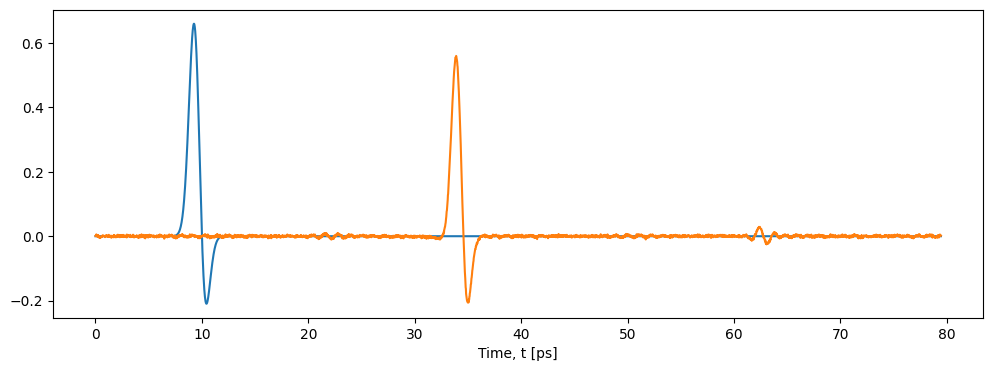

In [9]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

# Experimental material parameters (ground truth)
material_params_exp = [(3.46+0.01j, 3 * 1e-3)]

# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0.002)
experimental_pulse = experimental_pulse[:L]


plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse)
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy())
plt.xlabel('Time, t [ps]')
plt.show()

In [3]:
# Initial guesses
n_init, k_init, D_init = 3.40, 0.015, 2.7e-3

# Create and run the optimizer
extractor = TimeDomainExtractor(reference_pulse, experimental_pulse, deltat, n_init, k_init, D_init, lr=0.001)
optimized_n, optimized_k, optimized_D = extractor.optimize(num_iterations=300, updates=30, alpha=10)

initial_params = [(n_init + 1j*k_init, D_init)]
initial_pulse = simulate_parallel(reference_pulse, initial_params, deltat)[1][:L]

Optimizing for 300 with loss multiplier 10.
Iteration 0, Loss: 0.043975844979286194, n: 3.4010000228881836, k: 0.0139999995008111, D: 0.002699999837204814
Iteration 30, Loss: 0.02917889505624771, n: 3.4073262214660645, k: -0.00635420810431242, D: 0.002699999837204814
Iteration 60, Loss: 0.02635548822581768, n: 3.4061648845672607, k: -0.01803438924252987, D: 0.002699999837204814
Iteration 90, Loss: 0.0248892679810524, n: 3.4040799140930176, k: -0.02699120342731476, D: 0.002699999837204814
Iteration 120, Loss: 0.02398308366537094, n: 3.401660442352295, k: -0.03469112887978554, D: 0.002699999837204814
Iteration 150, Loss: 0.023302512243390083, n: 3.3990983963012695, k: -0.04156535863876343, D: 0.002699999837204814
Iteration 180, Loss: 0.022822285071015358, n: 3.3964905738830566, k: -0.047826096415519714, D: 0.002699999837204814
Iteration 210, Loss: 0.022403942421078682, n: 3.393937110900879, k: -0.05360791087150574, D: 0.002699999837204814
Iteration 240, Loss: 0.022115346044301987, n: 3.3

[((3.3906917572021484-0.06073148548603058j), 0.002699999837204814)]


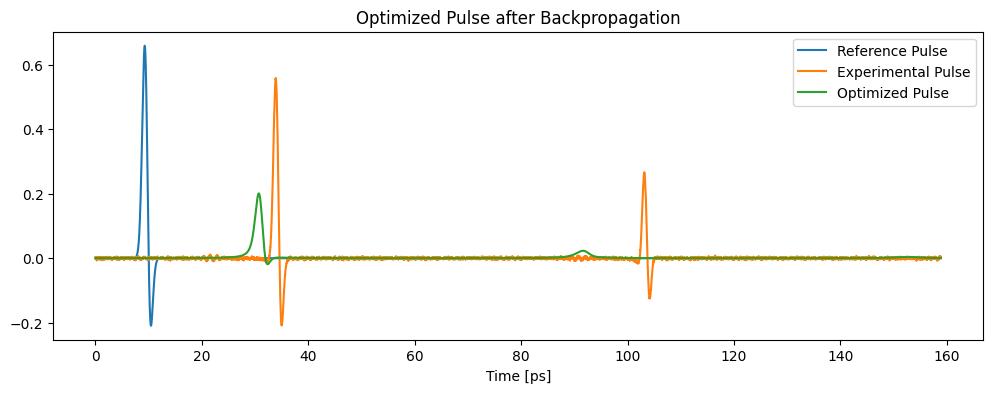

In [4]:
best_params = [(optimized_n + 1j*optimized_k, optimized_D)]
print(best_params)
best_pulse = simulate_parallel(reference_pulse, best_params, deltat)[1][:L]

# Plot results
plt.figure(figsize=(12, 4))
plt.plot(t_axis * 1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis * 1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
#plt.plot(t_axis * 1e12, initial_pulse.detach().cpu().numpy(), label='Initial Pulse')
plt.plot(t_axis * 1e12, best_pulse.detach().numpy(), label='Optimized Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.title('Optimized Pulse after Backpropagation')
plt.show()

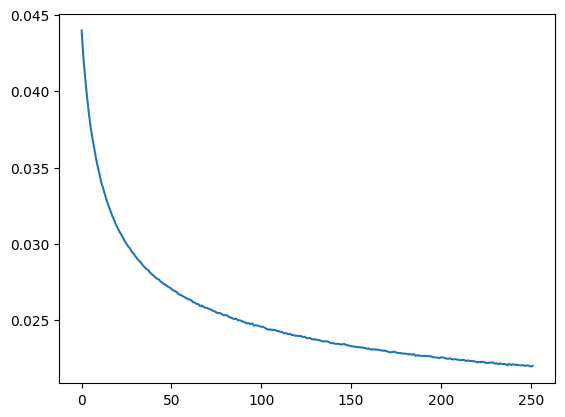

In [5]:
plt.plot(extractor.loss_history)
plt.show()

In [6]:
print(f'forward pass single run time: {extractor.forward_time}s')
print(f'backwards pass single run time: {extractor.backwards_time}s')
print(f'optimizer single run time: {extractor.optimizer_time}s')

forward pass single run time: 1.1433222079940606s
backwards pass single run time: 3.005256291013211s
optimizer single run time: 0.00024237498291768134s


In [7]:
print(f'forward pass 100 iter run time: {extractor.forward_time * 300} s')
print(f'backwards pass 100 iter run time: {extractor.backwards_time * 300} s')
print(f'optimizer 100 iter run time: {extractor.optimizer_time * 300} s')

forward pass 100 iter run time: 342.9966623982182 s
backwards pass 100 iter run time: 901.5768873039633 s
optimizer 100 iter run time: 0.0727124948753044 s
